# Modeling: PMD ARIMA, FB Prophet

### Overview: 

In the baseline modeling notebook, an ARIMA(1,1,2) was used. The model had a difficult time fitting to the dataset, as the data has little seasonality and a trend encompassing two large peaks, with a valley in between that dominates over 80% of the time series. The MAPE for the baseline model was over 600%, indicating a need for a new strategy. In this notebook, I will build PMD ARIMA and Prophet models, with the same time series data. We will compare the MAPE and other performance metrics against the output of three other time-series forecasting models. 

In addition to creating models using the same time frame as the baseline model, I will use smaller time frames to train the PMD ARIMA and Prophet models to a more static dataset within the larger scope of a difficultly variant dataset. The smaller time frames will be: 
- July 2018-July 2020: This is the valley between two peaks for this dataset
- Beginning of dataset to January 2019: This encompasses the first large peak

**1. Sourcing and Loading**
- Load relevant libraries 
- Load the data as DF
- Clean the DF
- Load previous ARIMA model and save results to DF

**2. Modeling**
- PMD ARIMA
    - save results to performance metrics DF
- Prophet
    - save results to performance metrics DF

**3. Evaluating**
- Data Visualization
- Comparative analysis of performance metrics 
- Proposals & Adaptations

**4. Conclusion**
- Action steps to report to stakeholders
- Further projects

# 1. Sourcing and Loading 

## ARIMA(1,1,2)

In [548]:
# import and load libraries
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline

In [623]:
ADA_df = pd.read_csv('../Capstone_Project_3/Data/ADA_df.csv')
df = ADA_df[['Date', 'Close']]
df = df.rename(columns={'Date':'Day', 'Close':'Price'})
df.head()

,Day,Price
0,2017-10-02,0.025932
1,2017-10-03,0.020816
2,2017-10-04,0.021931
3,2017-10-05,0.021489
4,2017-10-06,0.018539


In [550]:
#convert 'Day' from an object to a datetime64. 
df['Day'] = pd.to_datetime(df['Day'])
df.set_index('Day', inplace = True)

In [551]:
#make 'Price' the predictor variable 'y' and check data type
y = df['Price']
y.describe()

count    1245.000000
mean        0.138757
std         0.177812
min         0.018539
25%         0.044328
50%         0.080952
75%         0.143573
max         1.324860
Name: Price, dtype: float64

In [552]:
#create log transformed predictor variable and create a train/test split. 
y_log = np.log(y)
split=int(len(y_log) * 0.8) 
y_train, y_test = y_log[0:split], y_log[split:len(y_log)]

In [553]:
# Import mean_absolute_percentage_error and ARIMA
from sklearn.metrics import mean_absolute_percentage_error 
from statsmodels.tsa.arima_model import ARIMA 
import warnings
warnings.filterwarnings("ignore")
#build model with parameters set to baseline model ARIMA(1,1,2)
p=1
d=1
q=2
model = ARIMA(y_test, order=(p,d,q))
model_fit = model.fit()
forecast = model_fit.forecast(30)

In [554]:
# create dataframe comparing results of test data to the pred data. 
Test_Orig_Price = np.exp(y_test)
Log_Y_Test = y_test
Pred_Log_Y = model_fit.predict()
Pred_Price = np.exp(Pred_Log_Y)
Residuals = Test_Orig_Price - Pred_Price

df[['Test_Orig_Price', 'Log_Y_Test', 'Pred_Log_Y', 'Pred_Price', 'Residuals']] = Test_Orig_Price, Log_Y_Test, Pred_Log_Y, Pred_Price, Residuals
df_baseline = df.drop(['Price'], axis=1).dropna()
df_baseline

,Test_Orig_Price,Log_Y_Test,Pred_Log_Y,Pred_Price,Residuals
Day,,,,,
2020-06-25,0.081691,-2.504812,0.013518,1.013610,-0.931919
2020-06-26,0.080561,-2.518741,0.013453,1.013544,-0.932983
2020-06-27,0.077679,-2.555176,0.012685,1.012765,-0.935087
2020-06-28,0.080392,-2.520843,0.011834,1.011904,-0.931512
2020-06-29,0.083870,-2.478491,0.010467,1.010522,-0.926653
...,...,...,...,...,...
2021-02-23,0.954709,-0.046349,0.024532,1.024835,-0.070126
2021-02-24,1.051657,0.050367,0.025076,1.025393,0.026263
2021-02-25,1.079116,0.076142,0.019426,1.019616,0.059500


In [555]:
#calculate MAPE for predicted price 
Test_Orig_Price_mape = Test_Orig_Price.drop(Test_Orig_Price.index[0])
baseline_mape = mean_absolute_percentage_error(Test_Orig_Price_mape, Pred_Price)
baseline_mape

6.2671417830549565

# 2. Modeling

## PMD ARIMA 

### A. Full time frame 

In [556]:
# import libraries
import seaborn as sns
from pmdarima.arima import auto_arima
from pmdarima.arima import ADFTest
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA

In [557]:
#tune hyperparameters on best model using auto_arima function from pmdarima.arima library
model=auto_arima(y_train,start_p=0,d=2,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=7, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20,n_fits=50)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1586.062, Time=0.28 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-2270.269, Time=0.56 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-2268.856, Time=2.43 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.63 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-2287.798, Time=3.42 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-2278.872, Time=1.30 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1993.088, Time=0.42 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-2269.094, Time=1.21 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-2271.404, Time=1.66 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-2270.968, Time=2.67 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-2281.793, Time=3.73 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-2096.918, Time=0.47 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-2269.740, Time=3.20 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-2267.785, Time=2.04 sec
 ARIMA(

In [558]:
#get summary data 
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  996
Model:               SARIMAX(0, 2, 4)   Log Likelihood                1149.899
Date:                Tue, 20 Jul 2021   AIC                          -2287.798
Time:                        13:18:22   BIC                          -2258.388
Sample:                             0   HQIC                         -2276.617
                                - 996                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -1.29e-05   5.36e-05     -0.240      0.810      -0.000    9.22e-05
ma.L1         -0.9930      0.015    -66.208      0.000      -1.022      -0.964
ma.L2          0.1196      0.023      5.274      0.000       0.075       0.164
ma.L3         -0.0613      0.034     -1.813      0.070      -0.127       0.005
ma.L4         -0.0492      0.029     -1.699      0.089      -0.106       0.008
sigma2         0.0058   8.98e-05     64.168      0.000       0.006       0.006
===================================================================================
Ljung-Box (L1) (Q):                   0.14   Jarque-Bera (JB):             19689.98
Prob(Q):                              0.70   Prob(JB):                         0.00
Heteroskedasticity (H):               0.25   Skew:                             1.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        24.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [559]:
#predict len(test)
pmd_pred_1 = pd.DataFrame(model.predict(len(y_test)),index=y_test.index)#pmd_pred_1 to differentiate between... 
#the different time frames we will use 
pmd_pred_1.columns = ['Pred_Price_PMD']
pmd_pred_1['Pred_Price_PMD'] = np.exp(pmd_pred_1['Pred_Price_PMD'])
pmd_pred_1

,Pred_Price_PMD
Day,
2020-06-24,0.083954
2020-06-25,0.084574
2020-06-26,0.084999
2020-06-27,0.085475
2020-06-28,0.085952
...,...
2021-02-23,0.225264
2021-02-24,0.225819
2021-02-25,0.226373


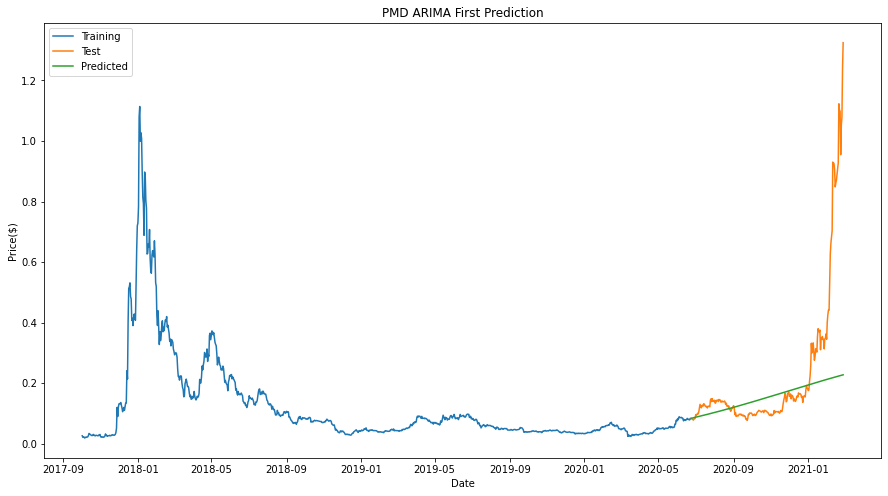

In [560]:
#plot results
y1=np.exp(y_train)#transform log data back to price
y2=np.exp(y_test)#transform log data back to price
plt.figure(figsize=(15,8))
plt.plot(y1,label="Training")
plt.plot(y2,label="Test")
plt.plot(pmd_pred_1,label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('PMD_1_Prediction.jpg')
plt.title('PMD ARIMA First Prediction')
plt.xlabel('Date')
plt.ylabel('Price($)')
plt.show()

In [561]:
# create dataframe comparing results of test data to the pred data. 
Test_Orig_Price = y2
Log_Y_Test = y_test
Pred_Log_Y_PMD = np.log(pmd_pred_1['Pred_Price_PMD'])
Pred_Price_PMD = pmd_pred_1['Pred_Price_PMD']
Residuals_PMD = Test_Orig_Price - Pred_Price_PMD

df_pmd = pd.DataFrame(y_test)
df_pmd['Test_Orig_Price'] = Test_Orig_Price
df_pmd['Log_Y_Test'] = Log_Y_Test
df_pmd['Pred_Log_Y_PMD'] = Pred_Log_Y_PMD
df_pmd['Pred_Price_PMD'] = Pred_Price_PMD
df_pmd['Residuals_PMD'] = Residuals_PMD
df_pmd1 = df_pmd.drop(['Price'], axis=1)
df_pmd1

,Test_Orig_Price,Log_Y_Test,Pred_Log_Y_PMD,Pred_Price_PMD,Residuals_PMD
Day,,,,,
2020-06-24,0.082583,-2.493952,-2.477487,0.083954,-0.001371
2020-06-25,0.081691,-2.504812,-2.470134,0.084574,-0.002883
2020-06-26,0.080561,-2.518741,-2.465113,0.084999,-0.004438
2020-06-27,0.077679,-2.555176,-2.459531,0.085475,-0.007796
2020-06-28,0.080392,-2.520843,-2.453963,0.085952,-0.005560
...,...,...,...,...,...
2021-02-23,0.954709,-0.046349,-1.490481,0.225264,0.729445
2021-02-24,1.051657,0.050367,-1.488021,0.225819,0.825837
2021-02-25,1.079116,0.076142,-1.485573,0.226373,0.852744


In [562]:
#calculate MAPE for PMD ARIMA predicted price 
pmd1_mape = mean_absolute_percentage_error(Test_Orig_Price, Pred_Price_PMD)
pmd1_mape

0.34026626151903056

#### The PMD ARIMA model has several helpful functions to tune the hyper-parameters, and select the best model. Setting the seasonality to False, the m to 7(Daily) and stepwise to False has allowed the function to select a model that did perform better than the baseline model. It is not fitting closely to the Test data, but it did at least account for some upward trend. It is important to note the improvement in the MAPE as well down from over 600% to 34%.  Let's try the same thing but on a different time frame. 

### B. Second Time Frame: July '18 - July '20 (Valley)

In [565]:
#create data frame from July '18-July '20
valley = (df['Day'] > '2018-06-30') & (df['Day'] <= '2020-07-31')
valley_df = df.loc[valley]
valley_df = valley_df[['Day', 'Price']]
valley_df.reset_index(drop=True, inplace=True)
valley_df

,Day,Price
0,2018-07-01,0.142208
1,2018-07-02,0.158278
2,2018-07-03,0.150655
3,2018-07-04,0.150960
4,2018-07-05,0.148921
...,...,...
757,2020-07-27,0.138771
758,2020-07-28,0.148598
759,2020-07-29,0.139879
760,2020-07-30,0.140588


In [566]:
#log transformation of Price column and train/test split of data
y_valley = valley_df['Price']
y_valley_log = np.log(y_valley)
split_valley=int(len(y_valley_log) * 0.8) 
y_train_valley, y_test_valley = y_valley_log[0:split_valley], y_valley_log[split_valley:len(y_valley_log)]

In [567]:
#pmd arima model 
model_valley=auto_arima(y_train_valley,start_p=0,d=2,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=7, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20,n_fits=50)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-1476.733, Time=0.09 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.12 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.49 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-1898.115, Time=1.57 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-1894.715, Time=1.66 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-1688.190, Time=0.26 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.34 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.89 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=2.41 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-1754.610, Time=0.36 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.99 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.41 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-1907.456, Time=1.86 sec
 ARIMA(3,2,0)(0,0,0)[0] intercept   : AIC=-1784.2

In [568]:
#get summary data for valley model
model_valley.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  609
Model:               SARIMAX(2, 2, 3)   Log Likelihood                 960.728
Date:                Tue, 20 Jul 2021   AIC                          -1907.456
Time:                        13:19:24   BIC                          -1876.596
Sample:                             0   HQIC                         -1895.449
                                - 609                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   3.421e-05    8.3e-05      0.412      0.680      -0.000       0.000
ar.L1         -1.1884      0.110    -10.818      0.000      -1.404      -0.973
ar.L2         -0.8735      0.086    -10.107      0.000      -1.043      -0.704
ma.L1          0.1534      0.109      1.412      0.158      -0.060       0.366
ma.L2         -0.2591      0.088     -2.944      0.003      -0.432      -0.087
ma.L3         -0.8622      0.082    -10.482      0.000      -1.023      -0.701
sigma2         0.0025      0.000     22.567      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.18   Jarque-Bera (JB):                60.99
Prob(Q):                              0.67   Prob(JB):                         0.00
Heteroskedasticity (H):               0.50   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [569]:
#predict len(test)
pmd_pred_2 = pd.DataFrame(model_valley.predict(len(y_test_valley)),index=y_test_valley.index)
pmd_pred_2.columns = ['Pred_Price_PMD2']
pmd_pred_2['Pred_Price_PMD2'] = np.exp(pmd_pred_2['Pred_Price_PMD2'])
pmd_pred_2

,Pred_Price_PMD2
609,0.047632
610,0.047658
611,0.047708
612,0.047789
613,0.047814
...,...
757,0.063281
758,0.063455
759,0.063631
760,0.063808


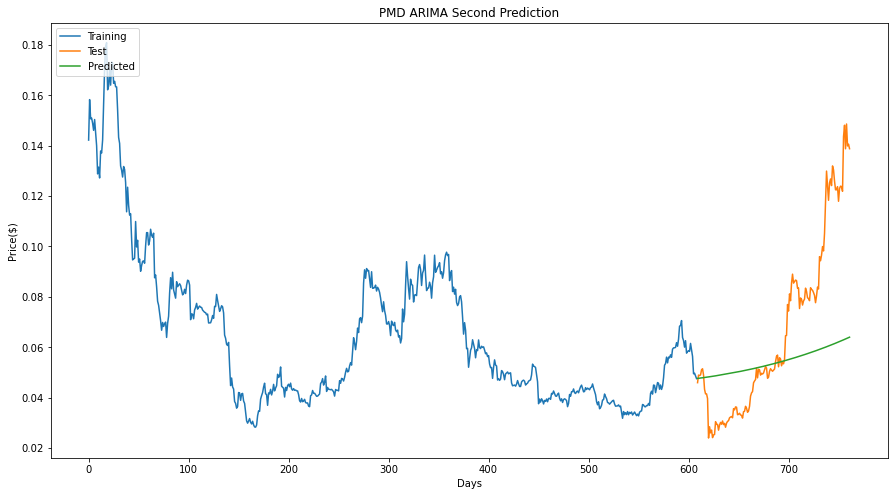

In [570]:
#plot results
y1=np.exp(y_train_valley)#transform log data back to price
y2=np.exp(y_test_valley)#transform log data back to price
plt.figure(figsize=(15,8))
plt.plot(y1,label="Training")
plt.plot(y2,label="Test")
plt.plot(pmd_pred_2['Pred_Price_PMD2'],label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('PMD_2_Prediction.jpg')
plt.title('PMD ARIMA Second Prediction')
plt.xlabel('Days')
plt.ylabel('Price($)')
plt.show()

In [571]:
# create dataframe comparing results of test data to the pred data. 
Test_Orig_Price = y2
Log_Y_Test = y_test_valley
Pred_Log_Y_PMD2 = np.log(pmd_pred_2['Pred_Price_PMD2'])
Pred_Price_PMD2 = pmd_pred_2['Pred_Price_PMD2']
Residuals_PMD2 = Test_Orig_Price - Pred_Price_PMD2

df_pmd2 = pd.DataFrame(y_test_valley)
df_pmd2['Test_Orig_Price'] = Test_Orig_Price
df_pmd2['Log_Y_Test'] = Log_Y_Test
df_pmd2['Pred_Log_Y_PMD2'] = Pred_Log_Y_PMD2
df_pmd2['Pred_Price_PMD2'] = Pred_Price_PMD2
df_pmd2['Residuals_PMD2'] = Residuals_PMD2
df_pmd2 = df_pmd2.drop(['Price'], axis=1)
df_pmd2

,Test_Orig_Price,Log_Y_Test,Pred_Log_Y_PMD2,Pred_Price_PMD2,Residuals_PMD2
609,0.045932,-3.080584,-3.044248,0.047632,-0.001700
610,0.048953,-3.016891,-3.043697,0.047658,0.001295
611,0.048761,-3.020826,-3.042649,0.047708,0.001053
612,0.049004,-3.015853,-3.040969,0.047789,0.001215
613,0.051057,-2.974810,-3.040440,0.047814,0.003243
...,...,...,...,...,...
757,0.138771,-1.974931,-2.760172,0.063281,0.075490
758,0.148598,-1.906509,-2.757418,0.063455,0.085143
759,0.139879,-1.966975,-2.754652,0.063631,0.076248
760,0.140588,-1.961918,-2.751875,0.063808,0.076780


In [572]:
#calculate MAPE for PMD ARIMA predicted price 
pmd2_mape = mean_absolute_percentage_error(Test_Orig_Price, Pred_Price_PMD2)
pmd2_mape

0.35153945976467377

#### Again, PMD Arima has selected a model that fits better than the baseline model and better than the first PMD Arima model. This is undoubtedly due to the more stationary time frame. Still, what looks like a low variance valley in the full scope of the Time Series actually sees quite a bit of price action change over two years. The MAPE is actually a bit worse at 35% compared to the first PMD ARIMA model. Now, let's see how PMD Arima fits to one of the peaks. 

### C. Third Time Frame: October '17 - January '19

In [573]:
#create data frame from Oct '17-January '19
df.reset_index(level=0, inplace=True)
peak = (df['Day'] > '2017-10-01') & (df['Day'] <= '2019-01-31')
peak_df = df.loc[peak]
peak_df = peak_df[['Day', 'Price']]
peak_df

,Day,Price
0,2017-10-02,0.025932
1,2017-10-03,0.020816
2,2017-10-04,0.021931
3,2017-10-05,0.021489
4,2017-10-06,0.018539
...,...,...
482,2019-01-27,0.041168
483,2019-01-28,0.038772
484,2019-01-29,0.038251
485,2019-01-30,0.039656


In [574]:
#log transformation of Price column and train/test split of data
y_peak = peak_df['Price']
y_peak_log = np.log(y_peak)
split_peak=int(len(y_peak_log) * 0.8) 
y_train_peak, y_test_peak = y_peak_log[0:split_peak], y_peak_log[split_peak:len(y_peak_log)]

In [575]:
#pmd arima model 
model_peak=auto_arima(y_train_peak,start_p=0,d=2,start_q=0,
          max_p=5,max_d=5,max_q=5, start_P=0,
          D=1, start_Q=0, max_P=5,max_D=5,
          max_Q=5, m=7, seasonal=False,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=False,
          random_state=20,n_fits=50)

 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-404.432, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-654.669, Time=0.25 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-652.703, Time=0.62 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.21 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=inf, Time=1.92 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-660.404, Time=2.09 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-561.410, Time=0.15 sec
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-652.717, Time=0.33 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-651.953, Time=0.53 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-660.757, Time=1.30 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-659.347, Time=1.48 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-600.682, Time=0.20 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-650.330, Time=0.69 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-651.976, Time=1.48 sec
 ARIMA(3,2,0)(0,0,0)[0] i

In [576]:
#get summary data for peak model 
model_peak.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  389
Model:               SARIMAX(3, 2, 1)   Log Likelihood                 337.704
Date:                Tue, 20 Jul 2021   AIC                           -663.407
Time:                        13:28:22   BIC                           -639.657
Sample:                             0   HQIC                          -653.990
                                - 389                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -5.899e-05      0.000     -0.452      0.651      -0.000       0.000
ar.L1          0.0007      0.027      0.028      0.978      -0.051       0.053
ar.L2          0.1982      0.036      5.447      0.000       0.127       0.269
ar.L3          0.0914      0.059      1.542      0.123      -0.025       0.208
ma.L1         -0.9857      0.018    -53.486      0.000      -1.022      -0.950
sigma2         0.0102      0.000     32.341      0.000       0.010       0.011
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              3302.79
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.13   Skew:                             1.98
Prob(H) (two-sided):                  0.00   Kurtosis:                        16.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [577]:
#predict len(test)
pmd_pred_3 = pd.DataFrame(model_peak.predict(len(y_test_peak)),index=y_test_peak.index)
pmd_pred_3.columns = ['Pred_Price_PMD3']
pmd_pred_3['Pred_Price_PMD3'] = np.exp(pmd_pred_3['Pred_Price_PMD3'])
pmd_pred_3

,Pred_Price_PMD3
389,0.073112
390,0.072414
391,0.071658
392,0.070888
393,0.070114
...,...
482,0.018523
483,0.018179
484,0.017841
485,0.017508


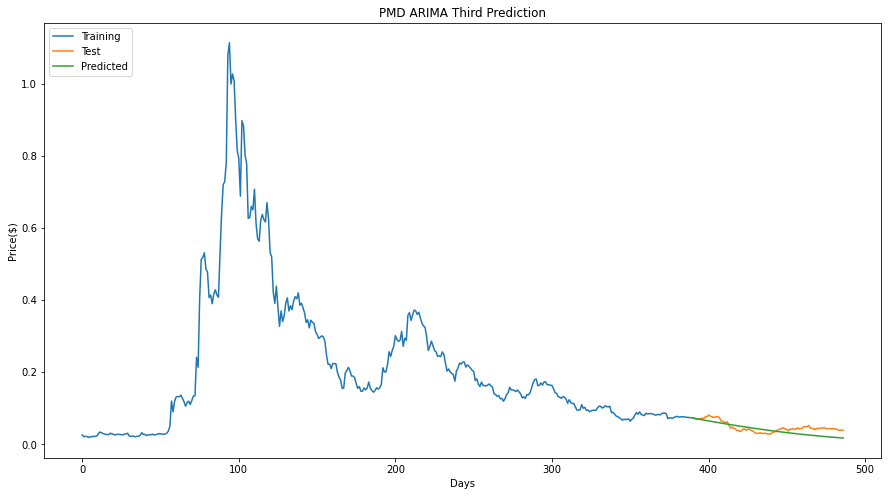

In [578]:
#plot results
y3=np.exp(y_train_peak)#transform log data back to price
y4=np.exp(y_test_peak)#transform log data back to price
plt.figure(figsize=(15,8))
plt.plot(y3,label="Training")
plt.plot(y4,label="Test")
plt.plot(pmd_pred_3['Pred_Price_PMD3'],label="Predicted")
plt.legend(loc = 'upper left')
plt.savefig('PMD_3_Prediction.jpg')
plt.title('PMD ARIMA Third Prediction')
plt.xlabel('Days')
plt.ylabel('Price($)')
plt.show()

In [579]:
# create dataframe comparing results of test data to the pred data. 
Test_Orig_Price = y4
Log_Y_Test = y_test_peak
Pred_Log_Y_PMD3 = np.log(pmd_pred_3['Pred_Price_PMD3'])
Pred_Price_PMD3 = pmd_pred_3['Pred_Price_PMD3']
Residuals_PMD3 = Test_Orig_Price - Pred_Price_PMD3

df_pmd3 = pd.DataFrame(y_test_peak)
df_pmd3['Test_Orig_Price'] = Test_Orig_Price
df_pmd3['Log_Y_Test'] = Log_Y_Test
df_pmd3['Pred_Log_Y_PMD3'] = Pred_Log_Y_PMD3
df_pmd3['Pred_Price_PMD3'] = Pred_Price_PMD3
df_pmd3['Residuals_PMD3'] = Residuals_PMD3
df_pmd3 = df_pmd3.drop(['Price'], axis=1)
df_pmd3

,Test_Orig_Price,Log_Y_Test,Pred_Log_Y_PMD3,Pred_Price_PMD3,Residuals_PMD3
389,0.073713,-2.607580,-2.615759,0.073112,0.000600
390,0.072886,-2.618861,-2.625360,0.072414,0.000472
391,0.073166,-2.615019,-2.635851,0.071658,0.001508
392,0.069627,-2.664604,-2.646649,0.070888,-0.001261
393,0.069647,-2.664311,-2.657632,0.070114,-0.000467
...,...,...,...,...,...
482,0.041168,-3.190096,-3.988767,0.018523,0.022645
483,0.038772,-3.250058,-4.007468,0.018179,0.020593
484,0.038251,-3.263596,-4.026251,0.017841,0.020410
485,0.039656,-3.227524,-4.045118,0.017508,0.022148


In [580]:
#calculate MAPE for PMD ARIMA predicted price 
pmd3_mape = mean_absolute_percentage_error(Test_Orig_Price, Pred_Price_PMD3)
pmd3_mape

0.2827957768440896

#### Of the PMD ARIMA models, the final attempt that highlighted data from the approximately the first 500 days of the entire time series has performed the best. The fit between the predicted price and actual price was closer than other models, with the MAPE being 6 points lower at 28% in comparision to the other PMD ARIMA models. Clearly, focusing on shorter time frames, as opposed to the entire scope of the time series, provides a better fit for the predicted values. We can therefore deduce that it would be beneficial to focus on a smaller set time than the entire series. Determining what criteria is necessary to narrow that time frame down will be critical in building an effective model. 

## Prophet

### A. Full time frame


In [581]:
from fbprophet import Prophet

In [582]:
#instantiate Prophet
model = Prophet()

In [583]:
#Prophet needs the timeseries to be labeled 'ds' and the predictor variable 'y'
pr_df = df.rename(columns = {'Day': 'ds', 'Price': 'y'})
pr_df

,index,ds,y
0,0,2017-10-02,0.025932
1,1,2017-10-03,0.020816
2,2,2017-10-04,0.021931
3,3,2017-10-05,0.021489
4,4,2017-10-06,0.018539
...,...,...,...
1240,1240,2021-02-23,0.954709
1241,1241,2021-02-24,1.051657
1242,1242,2021-02-25,1.079116
1243,1243,2021-02-26,1.241105


In [584]:
#log transform 'y'
pr_df['y'] = np.log(pr_df['y'])
pr_df

,index,ds,y
0,0,2017-10-02,-3.652285
1,1,2017-10-03,-3.872043
2,2,2017-10-04,-3.819831
3,3,2017-10-05,-3.840228
4,4,2017-10-06,-3.987873
...,...,...,...
1240,1240,2021-02-23,-0.046349
1241,1241,2021-02-24,0.050367
1242,1242,2021-02-25,0.076142
1243,1243,2021-02-26,0.216002


In [585]:
#train/test split
split=int(len(pr_df['y']) * 0.8) 
y_train_pr, y_test_pr = pr_df[0:split], pr_df[split:len(y_log)]

In [586]:
#fit model to train data 
model.fit(y_train_pr)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [587]:
y_test_pr_df = pd.DataFrame(y_test_pr)
future = y_test_pr_df.drop('y', axis=1)
pr_pred = model.predict(future)

In [588]:
pr_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-06-24,-3.208629,-3.200075,-2.564327,-3.208629,-3.208629,0.326734,0.326734,0.326734,-0.002364,-0.002364,-0.002364,0.329098,0.329098,0.329098,0.0,0.0,0.0,-2.881895
1,2020-06-25,-3.209482,-3.231783,-2.588960,-3.209482,-3.209482,0.299826,0.299826,0.299826,-0.009942,-0.009942,-0.009942,0.309768,0.309768,0.309768,0.0,0.0,0.0,-2.909656
2,2020-06-26,-3.210335,-3.241263,-2.619225,-3.210335,-3.210335,0.285916,0.285916,0.285916,-0.005076,-0.005076,-0.005076,0.290992,0.290992,0.290992,0.0,0.0,0.0,-2.924419
3,2020-06-27,-3.211187,-3.251134,-2.589402,-3.211187,-3.211187,0.278788,0.278788,0.278788,0.005725,0.005725,0.005725,0.273063,0.273063,0.273063,0.0,0.0,0.0,-2.932399
4,2020-06-28,-3.212040,-3.279749,-2.647884,-3.212040,-3.212040,0.257386,0.257386,0.257386,0.001135,0.001135,0.001135,0.256251,0.256251,0.256251,0.0,0.0,0.0,-2.954655
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2021-02-23,-3.416687,-4.697015,-2.094131,-4.775156,-2.182993,0.042068,0.042068,0.042068,0.005246,0.005246,0.005246,0.036822,0.036822,0.036822,0.0,0.0,0.0,-3.374619
245,2021-02-24,-3.417540,-4.753205,-2.040650,-4.783456,-2.173932,0.024206,0.024206,0.024206,-0.002364,-0.002364,-0.002364,0.026570,0.026570,0.026570,0.0,0.0,0.0,-3.393333
246,2021-02-25,-3.418392,-4.823695,-2.132672,-4.791757,-2.167039,0.004596,0.004596,0.004596,-0.009942,-0.009942,-0.009942,0.014538,0.014538,0.014538,0.0,0.0,0.0,-3.413797
247,2021-02-26,-3.419245,-4.822320,-2.147627,-4.799752,-2.163356,-0.004262,-0.004262,-0.004262,-0.005076,-0.005076,-0.005076,0.000814,0.000814,0.000814,0.0,0.0,0.0,-3.423507


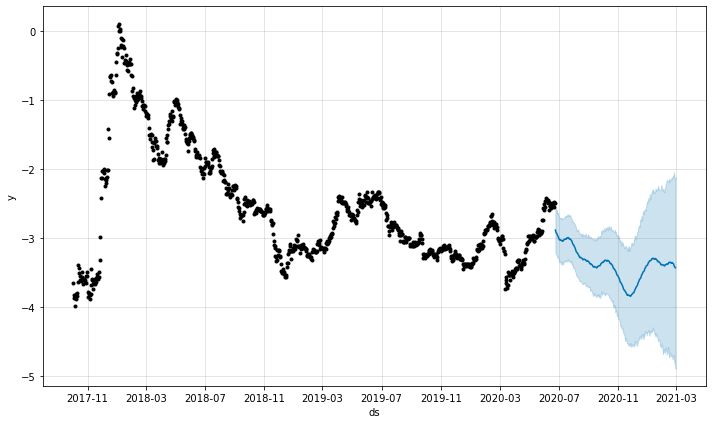

In [589]:
#plot forecast
model.plot(pr_pred);

In [590]:
#revisualize findings for closer examination between prediction and test
#set dataframes to same index
pr_df.set_index('ds', inplace=True)
pr_pred.set_index('ds', inplace=True)

In [591]:
viz_df = pr_df.join(pr_pred[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df

,index,y,yhat,yhat_lower,yhat_upper
ds,,,,,
2017-10-02,0,-3.652285,NaN,NaN,NaN
2017-10-03,1,-3.872043,NaN,NaN,NaN
2017-10-04,2,-3.819831,NaN,NaN,NaN
2017-10-05,3,-3.840228,NaN,NaN,NaN
2017-10-06,4,-3.987873,NaN,NaN,NaN
...,...,...,...,...,...
2021-02-23,1240,-0.046349,-3.374619,-4.697015,-2.094131
2021-02-24,1241,0.050367,-3.393333,-4.753205,-2.040650
2021-02-25,1242,0.076142,-3.413797,-4.823695,-2.132672


<AxesSubplot:xlabel='ds'>

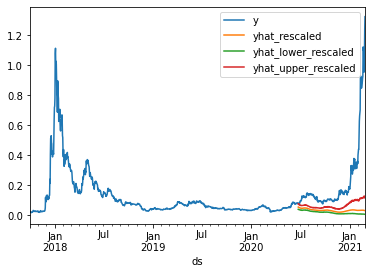

In [592]:
#adjust columns from log transformation 
viz_df['y'] = np.exp(viz_df['y'])
viz_df['yhat_rescaled'] = np.exp(viz_df['yhat'])
viz_df['yhat_lower_rescaled'] = np.exp(viz_df['yhat_lower'])
viz_df['yhat_upper_rescaled'] = np.exp(viz_df['yhat_upper'])
viz_df[['y', 'yhat_rescaled', 'yhat_lower_rescaled', 'yhat_upper_rescaled']].plot()


In [593]:
#create dataframe of results
pr_test = viz_df['y'][-249:]
Residuals = pr_test - viz_df['yhat_rescaled'].dropna()
viz_df['Residuals'] = Residuals
viz_df = viz_df.dropna()
viz_df

,index,y,yhat,yhat_lower,yhat_upper,yhat_rescaled,yhat_lower_rescaled,yhat_upper_rescaled,Residuals
ds,,,,,,,,,
2020-06-24,996,0.082583,-2.881895,-3.200075,-2.564327,0.056028,0.040759,0.076971,0.026554
2020-06-25,997,0.081691,-2.909656,-3.231783,-2.588960,0.054494,0.039487,0.075098,0.027196
2020-06-26,998,0.080561,-2.924419,-3.241263,-2.619225,0.053696,0.039114,0.072859,0.026865
2020-06-27,999,0.077679,-2.932399,-3.251134,-2.589402,0.053269,0.038730,0.075065,0.024409
2020-06-28,1000,0.080392,-2.954655,-3.279749,-2.647884,0.052097,0.037638,0.070801,0.028295
...,...,...,...,...,...,...,...,...,...
2021-02-23,1240,0.954709,-3.374619,-4.697015,-2.094131,0.034231,0.009122,0.123177,0.920478
2021-02-24,1241,1.051657,-3.393333,-4.753205,-2.040650,0.033597,0.008624,0.129944,1.018060
2021-02-25,1242,1.079116,-3.413797,-4.823695,-2.132672,0.032916,0.008037,0.118520,1.046200


In [594]:
#calculate MAPE for Prophet model
mape_pr = mean_absolute_percentage_error(viz_df['y'], viz_df['yhat_rescaled'])
mape_pr, baseline_mape, pmd1_mape

(0.7444135663377365, 6.2671417830549565, 0.34026626151903056)

#### The initial visualization of the Prophet model looks promising in the range of potential prices is gives. When we extracted the predicted price, it's upper and lower bounds, transform them and plot them against the test price, we get a more accurate representation of the fit of this model. It doesn't predict as well as the PMD ARIMA model on the same time frame. Let's run it through the other two time frames and see what type of insights we can gather. 

### B. Second Time Frame: July '18 - July '20 (Valley)

In [597]:
#instantiate Prophet
model1 = Prophet()

In [598]:
#create data frame from July '18-July '20
valley = (df['Day'] > '2018-06-30') & (df['Day'] <= '2020-07-31')
valley_df = df.loc[valley]
valley_df = valley_df[['Day', 'Price']]
valley_df.reset_index(drop=True, inplace=True)
valley_df

,Day,Price
0,2018-07-01,0.142208
1,2018-07-02,0.158278
2,2018-07-03,0.150655
3,2018-07-04,0.150960
4,2018-07-05,0.148921
...,...,...
757,2020-07-27,0.138771
758,2020-07-28,0.148598
759,2020-07-29,0.139879
760,2020-07-30,0.140588


In [599]:
#change column names
pr_df_valley = valley_df.rename(columns = {'Day': 'ds', 'Price': 'y'})
pr_df_valley

,ds,y
0,2018-07-01,0.142208
1,2018-07-02,0.158278
2,2018-07-03,0.150655
3,2018-07-04,0.150960
4,2018-07-05,0.148921
...,...,...
757,2020-07-27,0.138771
758,2020-07-28,0.148598
759,2020-07-29,0.139879
760,2020-07-30,0.140588


In [600]:
#log transform 'y'
pr_df_valley['y'] = np.log(pr_df_valley['y'])
pr_df_valley

,ds,y
0,2018-07-01,-1.950465
1,2018-07-02,-1.843402
2,2018-07-03,-1.892763
3,2018-07-04,-1.890740
4,2018-07-05,-1.904339
...,...,...
757,2020-07-27,-1.974931
758,2020-07-28,-1.906509
759,2020-07-29,-1.966975
760,2020-07-30,-1.961918


In [601]:
#train/test split
split=int(len(pr_df_valley['y']) * 0.8) 
y_train_pr_valley, y_test_pr_valley = pr_df_valley[0:split], pr_df_valley[split:len(pr_df_valley['y'])]

In [602]:
#fit train set
model1.fit(y_train_pr_valley)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [603]:
#predict 
y_test_pr_valley = pd.DataFrame(y_test_pr_valley)
future = y_test_pr_valley.drop('y', axis=1)
pr_valley_pred = model1.predict(future)

In [604]:
pr_valley_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-01,-2.973342,-3.157880,-2.777814,-2.973342,-2.973342,0.005358,0.005358,0.005358,0.005358,0.005358,0.005358,0.0,0.0,0.0,-2.967984
1,2020-03-02,-2.970788,-3.163223,-2.758485,-2.970788,-2.970788,0.001942,0.001942,0.001942,0.001942,0.001942,0.001942,0.0,0.0,0.0,-2.968846
2,2020-03-03,-2.968235,-3.168698,-2.778234,-2.968235,-2.968235,0.000738,0.000738,0.000738,0.000738,0.000738,0.000738,0.0,0.0,0.0,-2.967497
3,2020-03-04,-2.965682,-3.156704,-2.749086,-2.965682,-2.965682,0.001971,0.001971,0.001971,0.001971,0.001971,0.001971,0.0,0.0,0.0,-2.963710
4,2020-03-05,-2.963128,-3.171566,-2.789754,-2.963128,-2.963128,-0.012777,-0.012777,-0.012777,-0.012777,-0.012777,-0.012777,0.0,0.0,0.0,-2.975905
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,2020-07-27,-2.595431,-3.190138,-1.973726,-3.128822,-1.993303,0.001942,0.001942,0.001942,0.001942,0.001942,0.001942,0.0,0.0,0.0,-2.593488
149,2020-07-28,-2.592877,-3.189244,-1.935065,-3.129858,-1.986882,0.000738,0.000738,0.000738,0.000738,0.000738,0.000738,0.0,0.0,0.0,-2.592139
150,2020-07-29,-2.590324,-3.144565,-1.913344,-3.128873,-1.980596,0.001971,0.001971,0.001971,0.001971,0.001971,0.001971,0.0,0.0,0.0,-2.588352
151,2020-07-30,-2.587770,-3.180235,-1.944915,-3.131585,-1.972256,-0.012777,-0.012777,-0.012777,-0.012777,-0.012777,-0.012777,0.0,0.0,0.0,-2.600547


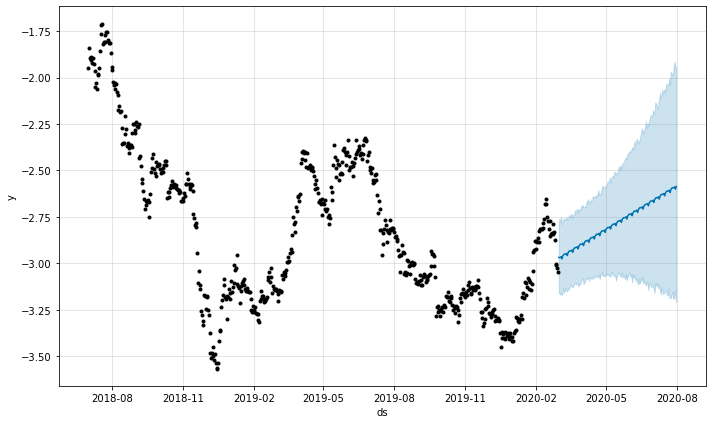

In [605]:
#plot results pr_valley_pred
model1.plot(pr_valley_pred);

In [606]:
#revisualize findings for closer examination between prediction and test
#set dataframes to same index
pr_df_valley.set_index('ds', inplace=True)
pr_valley_pred.set_index('ds', inplace=True)
viz_df_valley = pr_df_valley.join(pr_valley_pred[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df_valley = viz_df_valley.dropna()
viz_df_valley

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2020-03-01,-3.080584,-2.967984,-3.157880,-2.777814
2020-03-02,-3.016891,-2.968846,-3.163223,-2.758485
2020-03-03,-3.020826,-2.967497,-3.168698,-2.778234
2020-03-04,-3.015853,-2.963710,-3.156704,-2.749086
2020-03-05,-2.974810,-2.975905,-3.171566,-2.789754
...,...,...,...,...
2020-07-27,-1.974931,-2.593488,-3.190138,-1.973726
2020-07-28,-1.906509,-2.592139,-3.189244,-1.935065
2020-07-29,-1.966975,-2.588352,-3.144565,-1.913344


<AxesSubplot:xlabel='ds'>

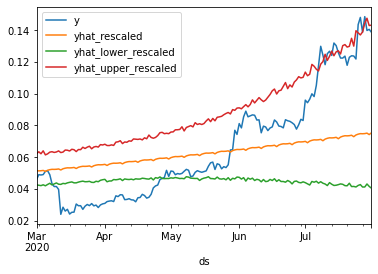

In [607]:
#adjust columns from log transformation and plot 
viz_df_valley['y'] = np.exp(viz_df_valley['y'])
viz_df_valley['yhat_rescaled'] = np.exp(viz_df_valley['yhat'])
viz_df_valley['yhat_lower_rescaled'] = np.exp(viz_df_valley['yhat_lower'])
viz_df_valley['yhat_upper_rescaled'] = np.exp(viz_df_valley['yhat_upper'])
viz_df_valley[['y', 'yhat_rescaled', 'yhat_lower_rescaled', 'yhat_upper_rescaled']].plot()

In [608]:
#create dataframe of results
pr_test_valley = viz_df_valley['y']
Residuals_valley_pr = pr_test_valley - viz_df_valley['yhat_rescaled']
viz_df_valley['Residuals_valley_pr'] = Residuals_valley_pr
viz_df_valley

,y,yhat,yhat_lower,yhat_upper,yhat_rescaled,yhat_lower_rescaled,yhat_upper_rescaled,Residuals_valley_pr
ds,,,,,,,,
2020-03-01,0.045932,-2.967984,-3.157880,-2.777814,0.051407,0.042516,0.062174,-0.005474
2020-03-02,0.048953,-2.968846,-3.163223,-2.758485,0.051363,0.042289,0.063388,-0.002409
2020-03-03,0.048761,-2.967497,-3.168698,-2.778234,0.051432,0.042058,0.062148,-0.002671
2020-03-04,0.049004,-2.963710,-3.156704,-2.749086,0.051627,0.042566,0.063986,-0.002623
2020-03-05,0.051057,-2.975905,-3.171566,-2.789754,0.051001,0.041938,0.061436,0.000056
...,...,...,...,...,...,...,...,...
2020-07-27,0.138771,-2.593488,-3.190138,-1.973726,0.074759,0.041166,0.138938,0.064012
2020-07-28,0.148598,-2.592139,-3.189244,-1.935065,0.074860,0.041203,0.144415,0.073739
2020-07-29,0.139879,-2.588352,-3.144565,-1.913344,0.075144,0.043086,0.147586,0.064736


In [609]:
#calculate mape of results 
mape_pr_valley = mean_absolute_percentage_error(pr_test_valley, viz_df_valley['yhat_rescaled'])
mape_pr_valley, pmd2_mape

(0.3952106176941794, 0.35153945976467377)

#### Here we have a lower MAPE, close to the performance of the PMD ARIMA on the same valley time frame (only 4% off). It is interesting to note that in this valley trend of the data, the Prophet model had a better time creating an upper and lower bound that fit the majority of the actual data points in the test data. The first Prophet model was well under the actual price, not being able to account for the dramatic upward trend in cost. Let's see how the Prophet model handles the first peak. 

### C. Third Time Frame: October '17 - January '19

In [610]:
#instantiate Prophet model
model2 = Prophet()

In [612]:
#create data frame from Oct '17-January '19
df.reset_index(level=0, inplace=True)
peak = (df['Day'] > '2017-10-01') & (df['Day'] <= '2019-01-31')
peak_df = df.loc[peak]
peak_df = peak_df[['Day', 'Price']]
peak_df

,Day,Price
0,2017-10-02,0.025932
1,2017-10-03,0.020816
2,2017-10-04,0.021931
3,2017-10-05,0.021489
4,2017-10-06,0.018539
...,...,...
482,2019-01-27,0.041168
483,2019-01-28,0.038772
484,2019-01-29,0.038251
485,2019-01-30,0.039656


In [613]:
#change column names
pr_df_peak = peak_df.rename(columns = {'Day': 'ds', 'Price': 'y'})
#log transform 'y'
pr_df_peak['y'] = np.log(pr_df_peak['y'])
pr_df_peak

,ds,y
0,2017-10-02,-3.652285
1,2017-10-03,-3.872043
2,2017-10-04,-3.819831
3,2017-10-05,-3.840228
4,2017-10-06,-3.987873
...,...,...
482,2019-01-27,-3.190096
483,2019-01-28,-3.250058
484,2019-01-29,-3.263596
485,2019-01-30,-3.227524


In [614]:
#train/test split
split=int(len(pr_df_peak['y']) * 0.8) 
y_train_pr_peak, y_test_pr_peak = pr_df_peak[0:split], pr_df_peak[split:len(pr_df_peak['y'])]

In [615]:
#fit train set
model2.fit(y_train_pr_peak)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [616]:
#predict 
y_test_pr_peak = pd.DataFrame(y_test_pr_peak)
future = y_test_pr_peak.drop('y', axis=1)
pr_peak_pred = model2.predict(future)

In [617]:
pr_peak_pred

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-10-26,-2.689373,-3.193502,-2.232160,-2.689373,-2.689373,-0.011860,-0.011860,-0.011860,-0.011860,-0.011860,-0.011860,0.0,0.0,0.0,-2.701232
1,2018-10-27,-2.696240,-3.139133,-2.197159,-2.696240,-2.696240,0.004761,0.004761,0.004761,0.004761,0.004761,0.004761,0.0,0.0,0.0,-2.691479
2,2018-10-28,-2.703107,-3.155166,-2.241373,-2.703107,-2.703107,0.000731,0.000731,0.000731,0.000731,0.000731,0.000731,0.0,0.0,0.0,-2.702376
3,2018-10-29,-2.709974,-3.198112,-2.219933,-2.710299,-2.709485,0.011495,0.011495,0.011495,0.011495,0.011495,0.011495,0.0,0.0,0.0,-2.698479
4,2018-10-30,-2.716841,-3.178371,-2.237626,-2.718068,-2.715530,0.011393,0.011393,0.011393,0.011393,0.011393,0.011393,0.0,0.0,0.0,-2.705448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93,2019-01-27,-3.328012,-4.006380,-2.697473,-3.743463,-2.950055,0.000731,0.000731,0.000731,0.000731,0.000731,0.000731,0.0,0.0,0.0,-3.327281
94,2019-01-28,-3.334879,-3.946004,-2.715453,-3.756201,-2.949645,0.011495,0.011495,0.011495,0.011495,0.011495,0.011495,0.0,0.0,0.0,-3.323384
95,2019-01-29,-3.341746,-3.971220,-2.690158,-3.770900,-2.949234,0.011393,0.011393,0.011393,0.011393,0.011393,0.011393,0.0,0.0,0.0,-3.330353
96,2019-01-30,-3.348613,-4.066525,-2.694823,-3.783265,-2.948137,-0.011840,-0.011840,-0.011840,-0.011840,-0.011840,-0.011840,0.0,0.0,0.0,-3.360453


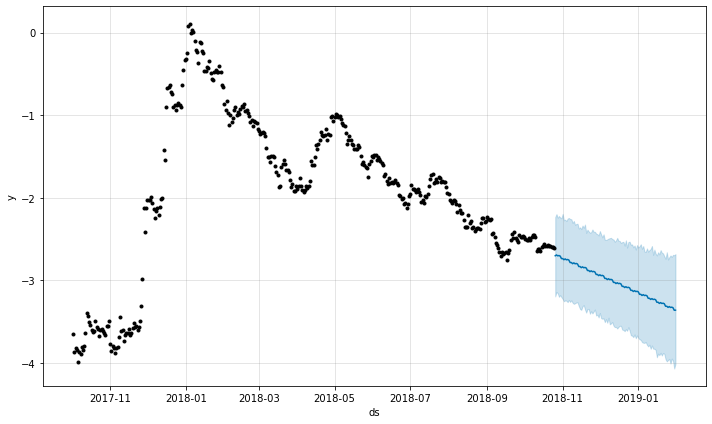

In [618]:
#plot results pr_valley_pred
model2.plot(pr_peak_pred);

In [619]:
#revisualize findings for closer examination between prediction and test
#set dataframes to same index
pr_df_peak.set_index('ds', inplace=True)
pr_peak_pred.set_index('ds', inplace=True)
viz_df_peak = pr_df_peak.join(pr_peak_pred[['yhat', 'yhat_lower','yhat_upper']], how = 'outer')
viz_df_peak = viz_df_peak.dropna()
viz_df_peak

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-10-26,-2.607580,-2.701232,-3.193502,-2.232160
2018-10-27,-2.618861,-2.691479,-3.139133,-2.197159
2018-10-28,-2.615019,-2.702376,-3.155166,-2.241373
2018-10-29,-2.664604,-2.698479,-3.198112,-2.219933
2018-10-30,-2.664311,-2.705448,-3.178371,-2.237626
...,...,...,...,...
2019-01-27,-3.190096,-3.327281,-4.006380,-2.697473
2019-01-28,-3.250058,-3.323384,-3.946004,-2.715453
2019-01-29,-3.263596,-3.330353,-3.971220,-2.690158


<AxesSubplot:xlabel='ds'>

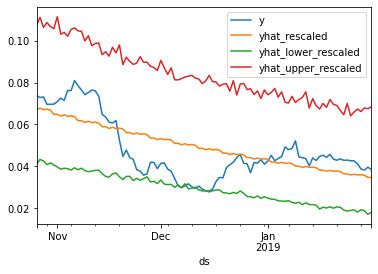

In [620]:
#adjust columns from log transformation and plot 
viz_df_peak['y'] = np.exp(viz_df_peak['y'])
viz_df_peak['yhat_rescaled'] = np.exp(viz_df_peak['yhat'])
viz_df_peak['yhat_lower_rescaled'] = np.exp(viz_df_peak['yhat_lower'])
viz_df_peak['yhat_upper_rescaled'] = np.exp(viz_df_peak['yhat_upper'])
viz_df_peak[['y', 'yhat_rescaled', 'yhat_lower_rescaled', 'yhat_upper_rescaled']].plot()

In [621]:
#create dataframe of results
pr_test_peak = viz_df_peak['y']
Residuals_peak_pr = pr_test_peak - viz_df_peak['yhat_rescaled']
viz_df_peak['Residuals_peak_pr'] = Residuals_peak_pr
viz_df_peak

,y,yhat,yhat_lower,yhat_upper,yhat_rescaled,yhat_lower_rescaled,yhat_upper_rescaled,Residuals_peak_pr
ds,,,,,,,,
2018-10-26,0.073713,-2.701232,-3.193502,-2.232160,0.067123,0.041028,0.107296,0.006590
2018-10-27,0.072886,-2.691479,-3.139133,-2.197159,0.067781,0.043320,0.111118,0.005105
2018-10-28,0.073166,-2.702376,-3.155166,-2.241373,0.067046,0.042631,0.106312,0.006120
2018-10-29,0.069627,-2.698479,-3.198112,-2.219933,0.067308,0.040839,0.108616,0.002319
2018-10-30,0.069647,-2.705448,-3.178371,-2.237626,0.066840,0.041653,0.106712,0.002807
...,...,...,...,...,...,...,...,...
2019-01-27,0.041168,-3.327281,-4.006380,-2.697473,0.035891,0.018199,0.067376,0.005277
2019-01-28,0.038772,-3.323384,-3.946004,-2.715453,0.036031,0.019332,0.066175,0.002741
2019-01-29,0.038251,-3.330353,-3.971220,-2.690158,0.035780,0.018850,0.067870,0.002470


In [622]:
#calculate mape of results 
mape_pr_peak = mean_absolute_percentage_error(pr_test_peak, viz_df_peak['yhat_rescaled'])
mape_pr_peak, pmd3_mape

(0.21993522348075265, 0.2827957768440896)

#### Again, we see the Prophet model perform better over this shorter time frame than the PMD ARIMA model performed over the same time frame. Thus far, the Prophet Model has the best fit to this DataFrame; the first peak of the entire time series. Now, let's plot the residuals of each model and compare the MAPE of each as well.

# 3. Evaluating 

## A. Distribution of Residuals 

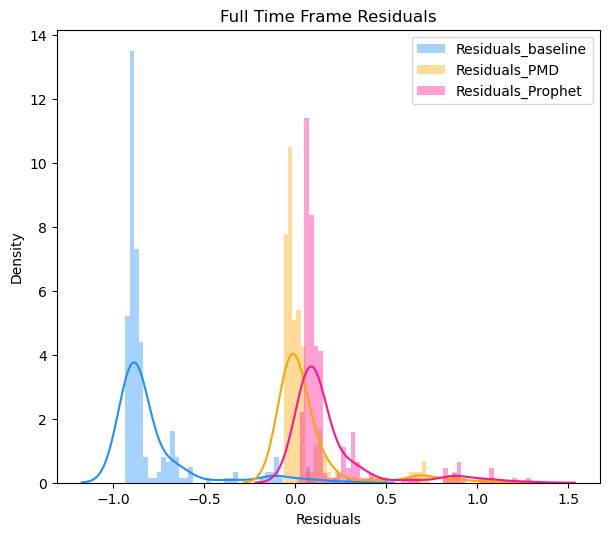

In [680]:
#import seaborn
import seaborn as sns
# set Residuals to individual variables to plot
x1 = df_baseline['Residuals']
x2 = Residuals_PMD
x3 = Residuals_PMD2
x4 = Residuals_PMD3
x5 = viz_df['Residuals']
x6 = Residuals_valley_pr
x7 = Residuals_peak_pr
#Compare Residuals for full time frame
plt.subplots(figsize=(7,6), dpi=100)
sns.distplot(x1, color="dodgerblue", label="Residuals_baseline")
sns.distplot(x2, color="orange", label="Residuals_PMD")
sns.distplot(x5, color="deeppink", label="Residuals_Prophet")

plt.title('Full Time Frame Residuals')
plt.legend();

#### As we can see in the first map, both the Prophet and PMD ARIMA model perform better than the baseline model by a signficant margin. The baseline model was significantly below most of the actual values. 

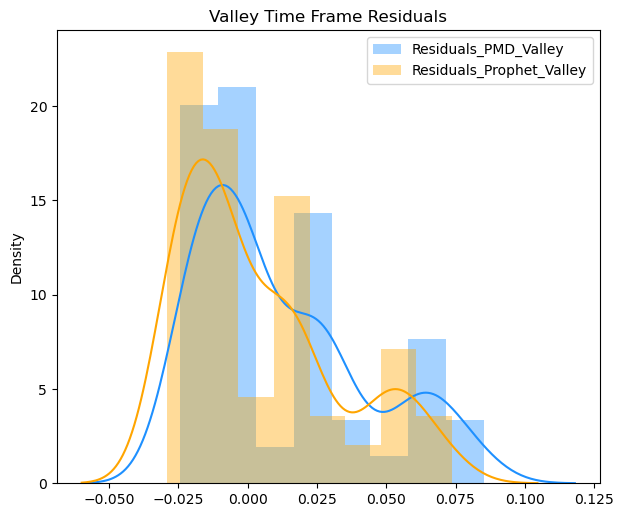

In [681]:
#plot Residuals for Valley Time Frame
plt.subplots(figsize=(7,6), dpi=100)
sns.distplot(x3, color="dodgerblue", label="Residuals_PMD_Valley")
sns.distplot(x6, color="orange", label="Residuals_Prophet_Valley")

plt.title('Valley Time Frame Residuals')
plt.legend();

#### As we can see by the comparison between the Valley time frames and the Prophet and PMD ARIMA model, they both are comparable, but the distribution has a tail to the right, with the overall performance of the model putting the mean vallues of the Residuals for each model closer to zero. 

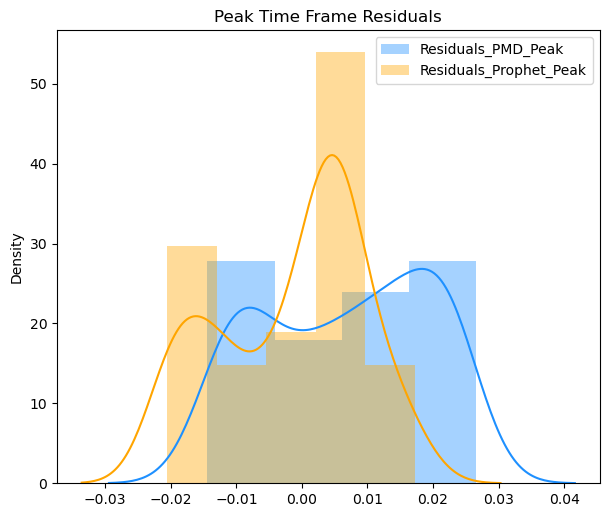

In [682]:
#Plot Residuals for Peak time frame
plt.subplots(figsize=(7,6), dpi=100)
sns.distplot(x4, color="dodgerblue", label="Residuals_PMD_Peak")
sns.distplot(x7, color="orange", label="Residuals_Prophet_Peak")

plt.title('Peak Time Frame Residuals')
plt.legend();

#### The final two Peak time frame models have a good distribution of Residuals, especially compared to the other models. Most of the data points are close to zero, with the Prophet model having a nice peak around zero. Let's compare MAPE values for each and determine our best model. 

In [704]:
MAPE_tbl = [baseline_mape, pmd1_mape, pmd2_mape, pmd3_mape, mape_pr, mape_pr_valley, mape_pr_peak] 
MAPE_df = pd.DataFrame(data=MAPE_tbl, columns=['MAPE'])
MAPE_df['Model'] = ['Baseline_MAPE', 'PMD_MAPE', 'PMD_Valley_MAPE', 'PMD_Peak_MAPE', 'Prophet_MAPE', 'Prophet_Valley_MAPE', 'Prophet_Peak_MAPE']
MAPE_df = MAPE_df[['Model', 'MAPE']]
MAPE_df.sort_values('MAPE')

,Model,MAPE
6,Prophet_Peak_MAPE,0.219935
3,PMD_Peak_MAPE,0.282796
1,PMD_MAPE,0.340266
2,PMD_Valley_MAPE,0.351539
5,Prophet_Valley_MAPE,0.395211
4,Prophet_MAPE,0.744414
0,Baseline_MAPE,6.267142


#### As mentioned before, the MAPE for the Peak time frames was best. This, in combination with the Residual plots, allows us to determine the best model to be the Prophet-Peak Time Frame. 

# 4. Conclusions

#### This modeling portion has been insightful for numerous reasons. We have learned that for a time series dataset lacking seasonality and stationarity like this one is, as well as a clear trend in any direction, it is incredibly difficult for any ARIMA model to take the entire dataset and attempt to fit future predictions to it. Where there is room for future analysis clearly lies in picking a condensed timeframe that fits the following criteria: A. It follows a clear trend(upward or downward) B. it does not encompass multiple peaks. Should that criteria be met, there is a good usecase for a model like PMD ARIMA or Prophet for that dataset. 

#### Future Steps: Predicting future price action of such a volatile currency must be taken with a grain of salt. Updating the Prophet model with most current data down to the second could provide interesting insight in projecting future price action. Entire dataframe would have to go back to the beginning of a macro trend and would have to be adjusted if a breakout of the current trend occured. Continuous maintainance and adjusting of the model would be necessary. Conversely, analysis of Market Volume could provide another avenue of predicting price action. Volume levels have a strong correlation to price action. 
